In [2]:
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Cargar Datos

In [4]:
usosSuelo_gdf = gpd.read_file("..\Datos\CORINE\\URBAN_ATLAS_AMB.shp")
buffers = gpd.read_file("..\Datos\Buffers\Buffers_Conjunto_25_5000.shp")
buffers.sort_values(by='layer',inplace=True)

Inspección:

In [5]:
usosSuelo_gdf.head(1)

,fid,country,fua_name,fua_code,code_2018,class_2018,prod_date,identifier,perimeter,area,comment,geometry
0,4.0,ES,Barcelona,ES002L2,12100,"Industrial, commercial, public, military and p...",2020-01,42067-ES002L2,257.338961,4236.598217,None,"POLYGON ((3653535.028 2062130.228, 3653538.434..."


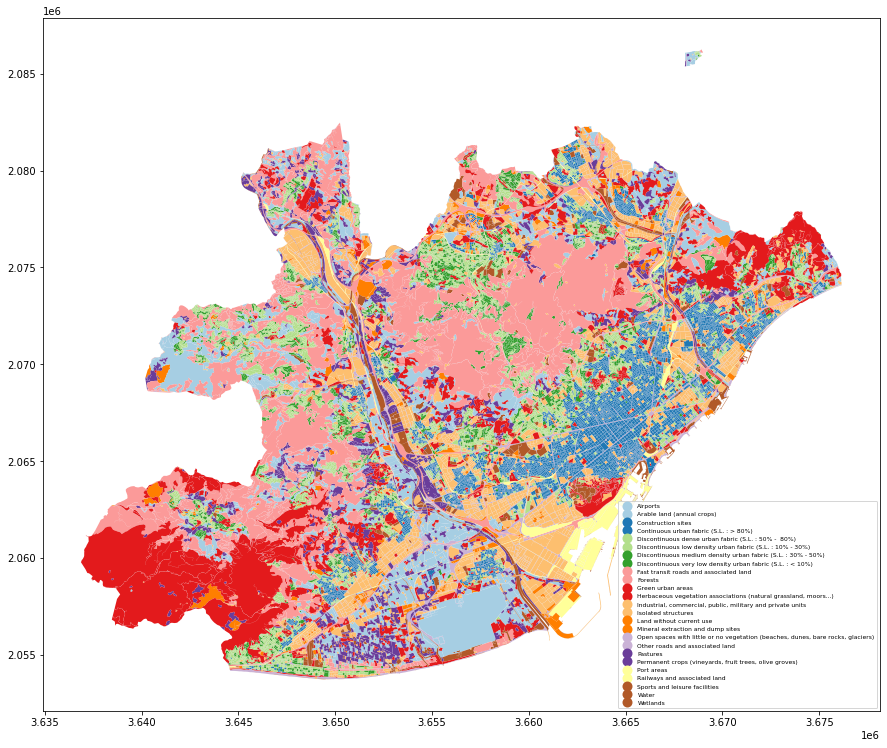

In [6]:
f, ax = plt.subplots(1,1,figsize=(15,15))
usosSuelo_gdf.plot(column='class_2018',ax=ax,cmap='Paired',
                    legend=True,legend_kwds={'loc': 'lower right','fontsize':6})
plt.show()

Recodificar Categorias:

In [7]:
usosSuelo_gdf['class_2018'] = usosSuelo_gdf['class_2018'].astype('category')
catMapping = {'Industrial, commercial, public, military and private units':'industryCommercial',
              'Other roads and associated land':'otherRoads',
              'Discontinuous low density urban fabric (S.L. : 10% - 30%)':'discLowDensUrbFab',
              'Isolated structures':'isolStruct',
              'Continuous urban fabric (S.L. : > 80%)':'contUrbFab',
              'Fast transit roads and associated land':'fastRoads',
              'Discontinuous dense urban fabric (S.L. : 50% -  80%)':'discDensUrbFab',
              'Green urban areas':'grUrbAreas',
              'Discontinuous medium density urban fabric (S.L. : 30% - 50%)':'discMedDensUrbFab',
              'Discontinuous very low density urban fabric (S.L. : < 10%)':'discVLowDensUrbFab',
              'Airports': 'airports', 
              'Port areas':'port', 
              'Railways and associated land':'railways',
              'Construction sites':'constructionSites', 
              'Mineral extraction and dump sites':'mininDump',
              'Land without current use':'landNoUse', 
              'Sports and leisure facilities':'sports',
              'Arable land (annual crops)':'annualCrops', 
              'Pastures':'pastures',
              'Permanent crops (vineyards, fruit trees, olive groves)':'permanentCrops',
              'Forests':'forest', 
              'Water':'water',
              'Herbaceous vegetation associations (natural grassland, moors...)':'herbVegetation',
              'Open spaces with little or no vegetation (beaches, dunes, bare rocks, glaciers)':'opSpaceNoVeg'}
usosSuelo_gdf['class_2018'].cat.rename_categories(catMapping,inplace=True)

In [8]:
usosSuelo_gdf['class_2018'] = usosSuelo_gdf['class_2018'].astype(str)

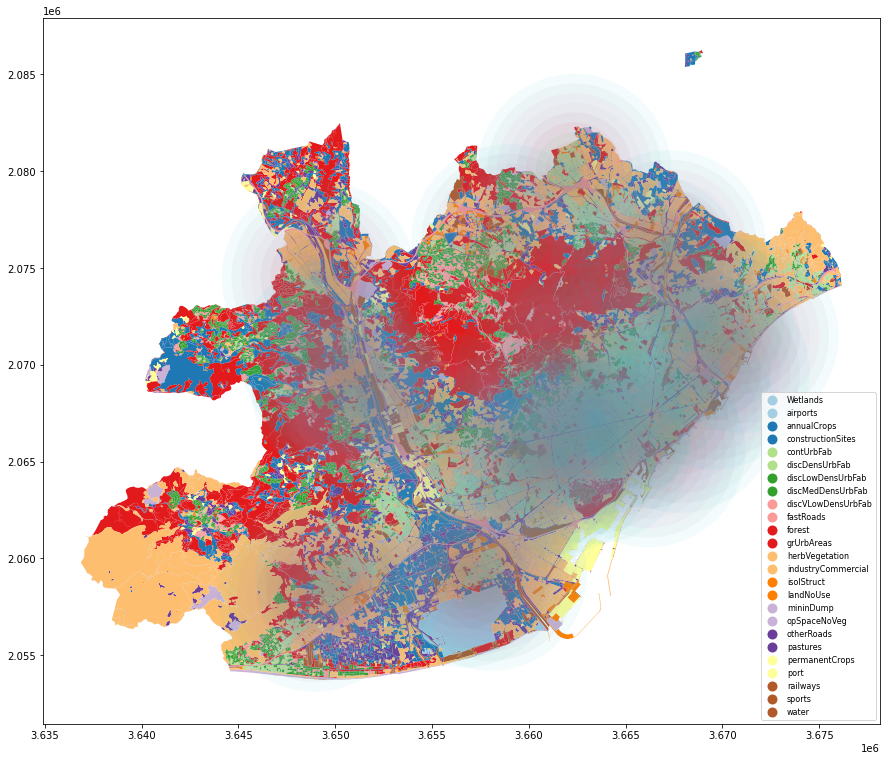

In [9]:
f, ax = plt.subplots(1,1,figsize=(15,15))
usosSuelo_gdf.plot(column='class_2018',ax=ax,cmap='Paired',
                    legend=True,legend_kwds={'loc': 'lower right','fontsize':8})
buffers.plot(column='layer',ax=ax, alpha=0.05)
plt.show()

# Calculo superficies tipo de suelo por buffer

Definir lista de buffers, estaciones y codigos de estaciones:

In [9]:
buf = ['b25','b50','b100','b300','b500','b1000', 'b1500', 'b2000','b2500', 'b3000','b3500', 'b4000','b4500','b5000']
est = list(buffers['NOM ESTACI'].unique())
est_cod = list(buffers['CODI EOI'].unique())

In [10]:
# Definición DF donde se pegarán los datos de longitud:
dfBufUsosSuelo=pd.DataFrame(est_cod,columns=['CODI EOI'])
dfBufUsosSuelo['ESTACION'] = est
# Calculo
for i,v in enumerate(buf):
    print(f'{i+1} - Procesando {v}...')
    # Filtrar buffers
    df_buffer = buffers[buffers['layer']== v ]
    # Intersección Usos Suelo y buffer
    df_aux = gpd.overlay(usosSuelo_gdf, df_buffer, how='intersection')
    # Calculo Area tipo suelo
    df_aux['AreaUsoSuelo']=0
    for i in range(df_aux.shape[0]):
        df_aux.iloc[i,24]=df_aux.iloc[i,23].area
    # Agrupación por Codigo Estación y Clase de Uso Suelo - Suma longitud Carretera
    df_aux1 = df_aux.groupby(by=['CODI EOI','class_2018']).sum('AreaUsoSuelo').reset_index(drop=False)
    df_aux1['buffer'] = v
    df_aux1['buffer_area'] = df_aux1['class_2018'] + '_' + df_aux1['buffer']
    df_aux1 = df_aux1[['CODI EOI','buffer_area','AreaUsoSuelo']]
    # Spread de columnas
    df_aux1 = pd.crosstab(index=df_aux1['CODI EOI'],
                          columns=df_aux1['buffer_area'],
                          values=df_aux1['AreaUsoSuelo'],
                          aggfunc='mean').reset_index(drop=False)
    # Join con dfBufCar
    dfBufUsosSuelo = dfBufUsosSuelo.merge(df_aux1, how='left',on='CODI EOI')
# Substituir NaN por 0
dfBufUsosSuelo = dfBufUsosSuelo.replace(np.nan, 0)
# Ordenar DF por Codigo EOI
dfBufUsosSuelo.sort_values(by='CODI EOI',inplace=True)

1 - Procesando b25...
2 - Procesando b50...
3 - Procesando b100...
4 - Procesando b300...
5 - Procesando b500...
6 - Procesando b1000...
7 - Procesando b1500...
8 - Procesando b2000...
9 - Procesando b2500...
10 - Procesando b3000...
11 - Procesando b3500...
12 - Procesando b4000...
13 - Procesando b4500...
14 - Procesando b5000...


In [11]:
dfBufUsosSuelo.to_csv('..\Datos\Datos_Procesados\Estacion_Buffers_AreaUsosSuelo_urbanAtlas.csv')